# Turkey earthquakes data analysis 2021 by Muhannad Daoud



the analysis example is taken from:

https://risk-engineering.org/notebook/data-analysis-earthquakes.html

the data source is a database I prepared and cleaned with main.py

In [2]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

In [3]:
#import the data from the database and turn it into a dataframe.
conn = sqlite3.connect('Database.sqlite')
query = "SELECT * FROM EarthQuake;"
df = pd.read_sql_query(query,conn)
#adding a new column for pandas date-time data type.
df['dateTime']=pd.to_datetime(df['date'] +' ' + df['time'])
#sorting the data according to date and time for visualisation and for better understanding for earthquakes activity.
df.sort_values("dateTime", inplace=True)


Plot the data to see whether we can identify any visible patterns.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 0, 'Magnitude')

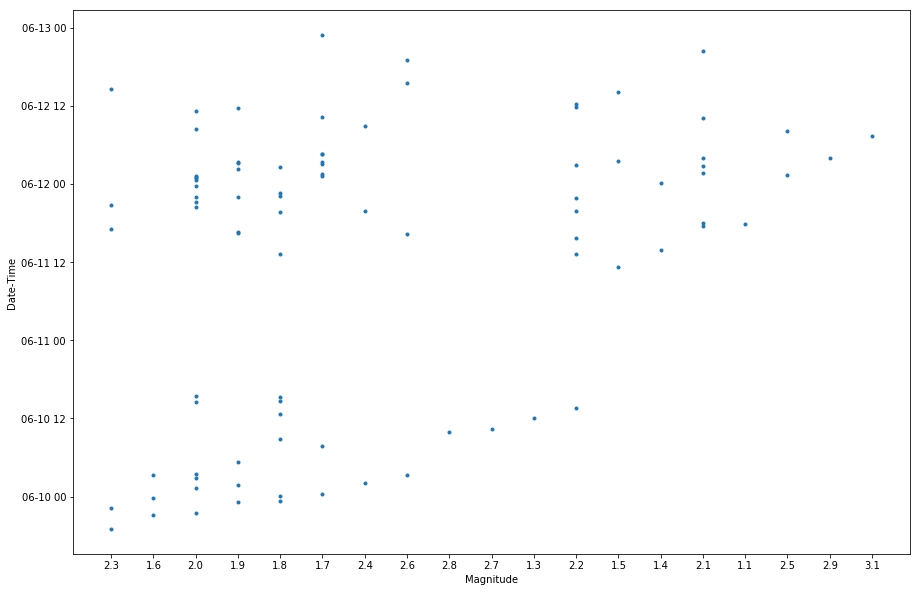

In [4]:
fig = plt.figure(figsize=(15,10))
plt.plot(df.magnitude,df.dateTime, ".");
plt.ylabel("Date-Time");
plt.xlabel("Magnitude")

There's no visible trend in this time series.

Let's examine the distribution of earthquake magnitudes

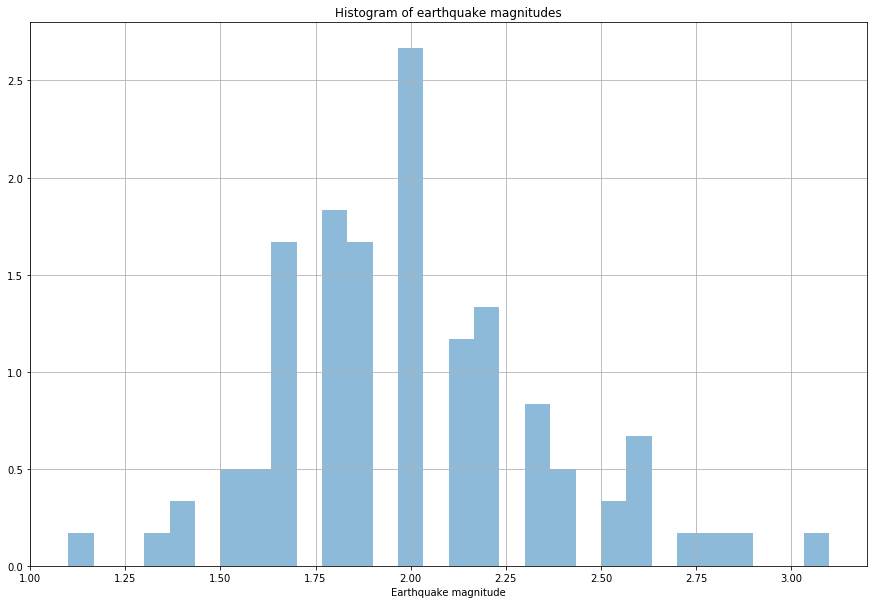

In [5]:
df.magnitude = df['magnitude'].astype(float)
df_TM= df[['dateTime','magnitude']] 
df_TM.magnitude.hist(density=True, alpha=0.5, bins=30,figsize=(15,10))
plt.xlabel("Earthquake magnitude")
plt.title("Histogram of earthquake magnitudes");

Earthquake arrivals follow a Poisson process. This means that interarrival times follow an exponential distribution.


We can attempt to fit an exponential distribution to the interarrival times.

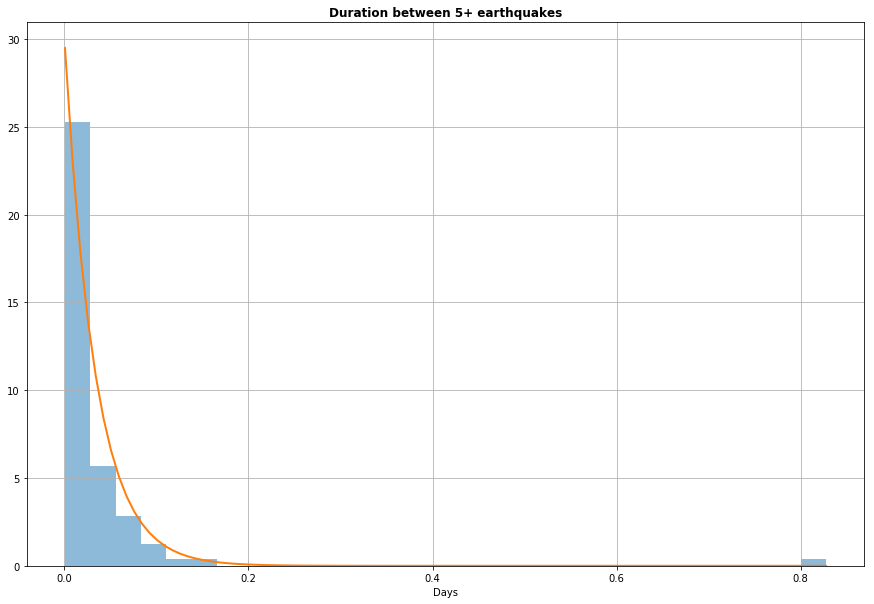

In [6]:
duration = df.dateTime.max() - df.dateTime.min()
density = len(df) / float(duration.days)
density  # events per day
# calculate the time delta between successive rows and convert into days
interarrival = df.dateTime.diff().dropna().apply(lambda x: x / numpy.timedelta64(1, "D"))
support = numpy.linspace(interarrival.min(), interarrival.max(), 100)
interarrival.hist(density=True, alpha=0.5, bins=30,figsize=(15,10))
plt.plot(support, scipy.stats.expon(scale=1/density).pdf(support), lw=2)
plt.title("Duration between 5+ earthquakes", weight="bold")
plt.xlabel("Days");

It looks like the inter-event times do indeed fit an exponential distribution well. To check, generate a probability plot against the exponential distribution. This shows quantiles from our sample against quantiles from the theoretical distribution. If the points are close to the diagonal red line, the sample closely follows the distribution.

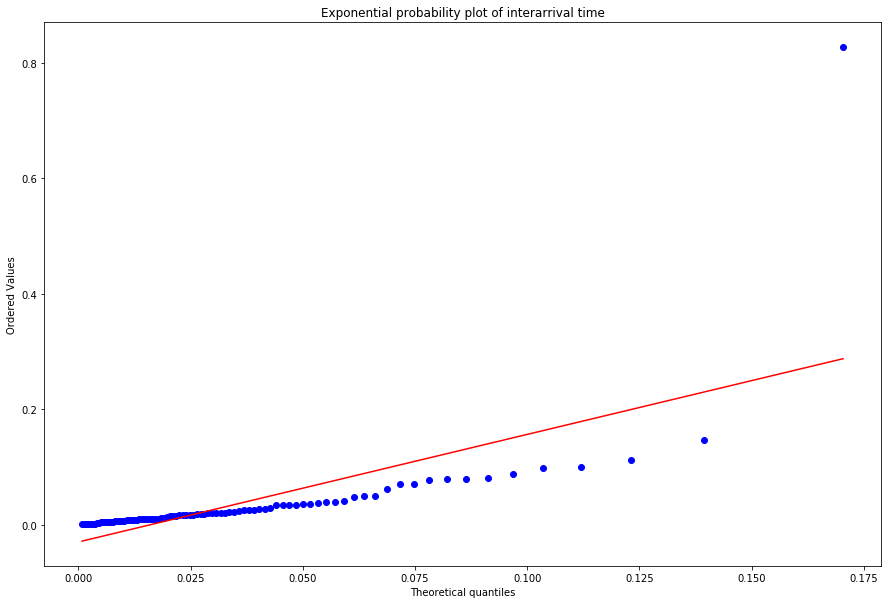

In [7]:
shape, loc = scipy.stats.expon.fit(interarrival)
scipy.stats.probplot(interarrival, 
                     dist="expon", sparams=(shape, loc), 
                     plot=plt.figure(figsize=(15,10)).add_subplot(111))
plt.title("Exponential probability plot of interarrival time");

A correlogram or autocorrelation plot tests whether elements of a time series are positively correlated, negatively correlated, or independent of each other. This is important to detect trends or cycles in time series data.

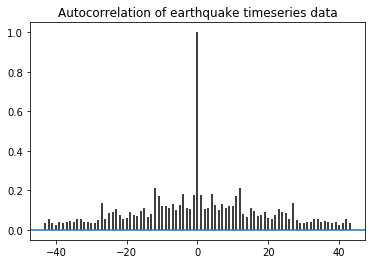

In [8]:
#A correlogram or autocorrelation plot tests whether elements of a time series are positively correlated, negatively correlated, or independent of each other. This is important to detect trends or cycles in time series data.
plt.acorr(interarrival, maxlags=43)
plt.title("Autocorrelation of earthquake timeseries data");

A bar chart to see the earthquake magnitude in each region

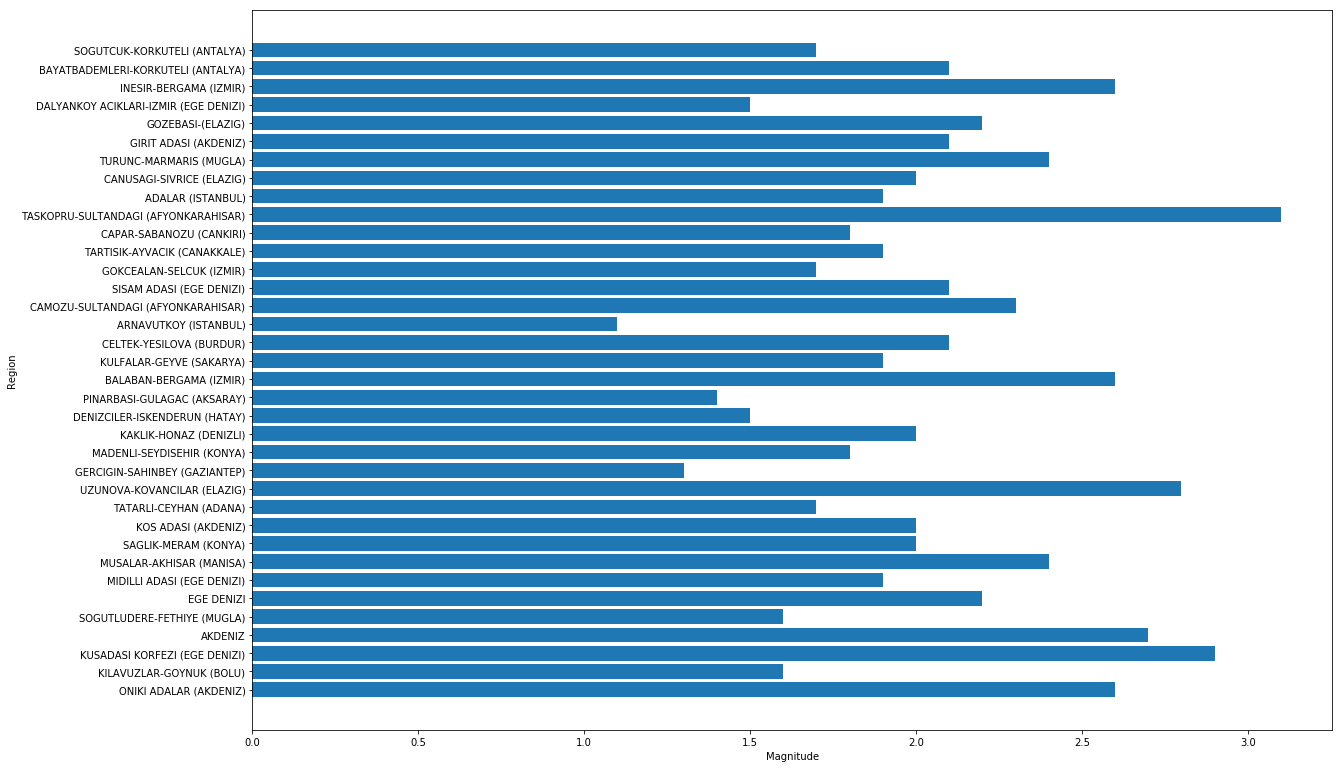

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
regions = df['region']
magnitudes = df['magnitude']
ax.barh(regions,magnitudes)
plt.xlabel('Magnitude')
plt.ylabel('Region')
plt.show()

A bar chart with the counts of earthquakes in each region.

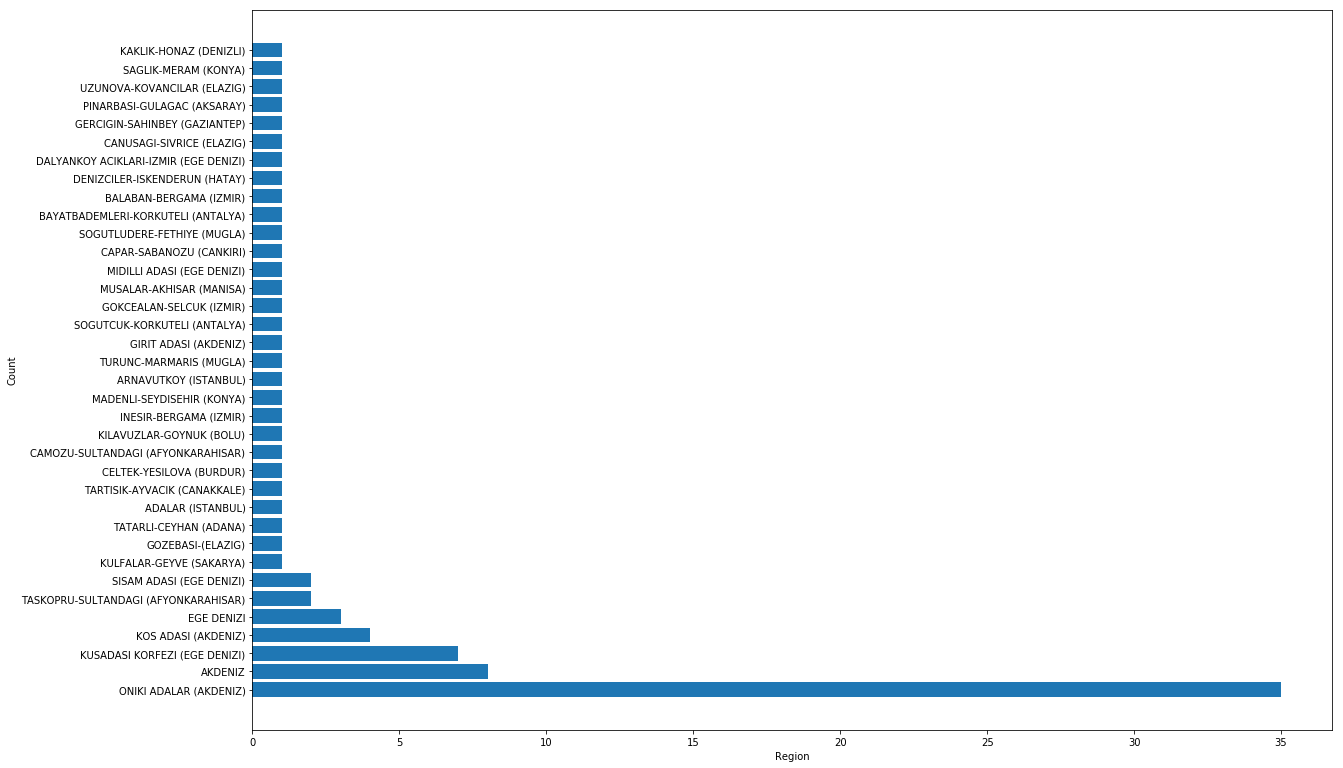

In [12]:
count = df.region.value_counts().rename_axis('Regions').reset_index(name='Count')
count
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
r = count['Regions']
c = count['Count']
ax.barh(r,c)
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()